In [1]:
import json
import h5py
import scipy.misc
import matplotlib
import numpy as np
from skimage import transform, filters
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
params = {
   'axes.labelsize': 8,
   'font.size': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
}
matplotlib.rcParams.update(params)

In [3]:
data = json.load(open('data/vqa_raw_test.json', 'r'))
att = h5py.File('results/san1-512/110000/attention_maps.h5')
res = json.load(open('results/san1-512/110000/OpenEnded_mscoco_lstm_results.json', 'r'))

In [4]:
att['maps'].shape

(1, 214354, 14, 14)

In [5]:
def get_blend_map(img, att_map, blur=True, overlap=True):
    att_map -= att_map.min()
    if att_map.max() > 0:
        att_map /= att_map.max()
    att_map = transform.resize(att_map, (img.shape[:2]), order = 3, mode='nearest')
    if blur:
        att_map = filters.gaussian_filter(att_map, 0.02*max(img.shape[:2]))
        att_map -= att_map.min()
        att_map /= att_map.max()
    cmap = plt.get_cmap('jet')
    att_map_v = cmap(att_map)
    att_map_v = np.delete(att_map_v, 3, 2)
    if overlap:
        att_map = 1*(1-att_map**0.7).reshape(att_map.shape + (1,))*img + (att_map**0.7).reshape(att_map.shape+(1,)) * att_map_v
    return att_map

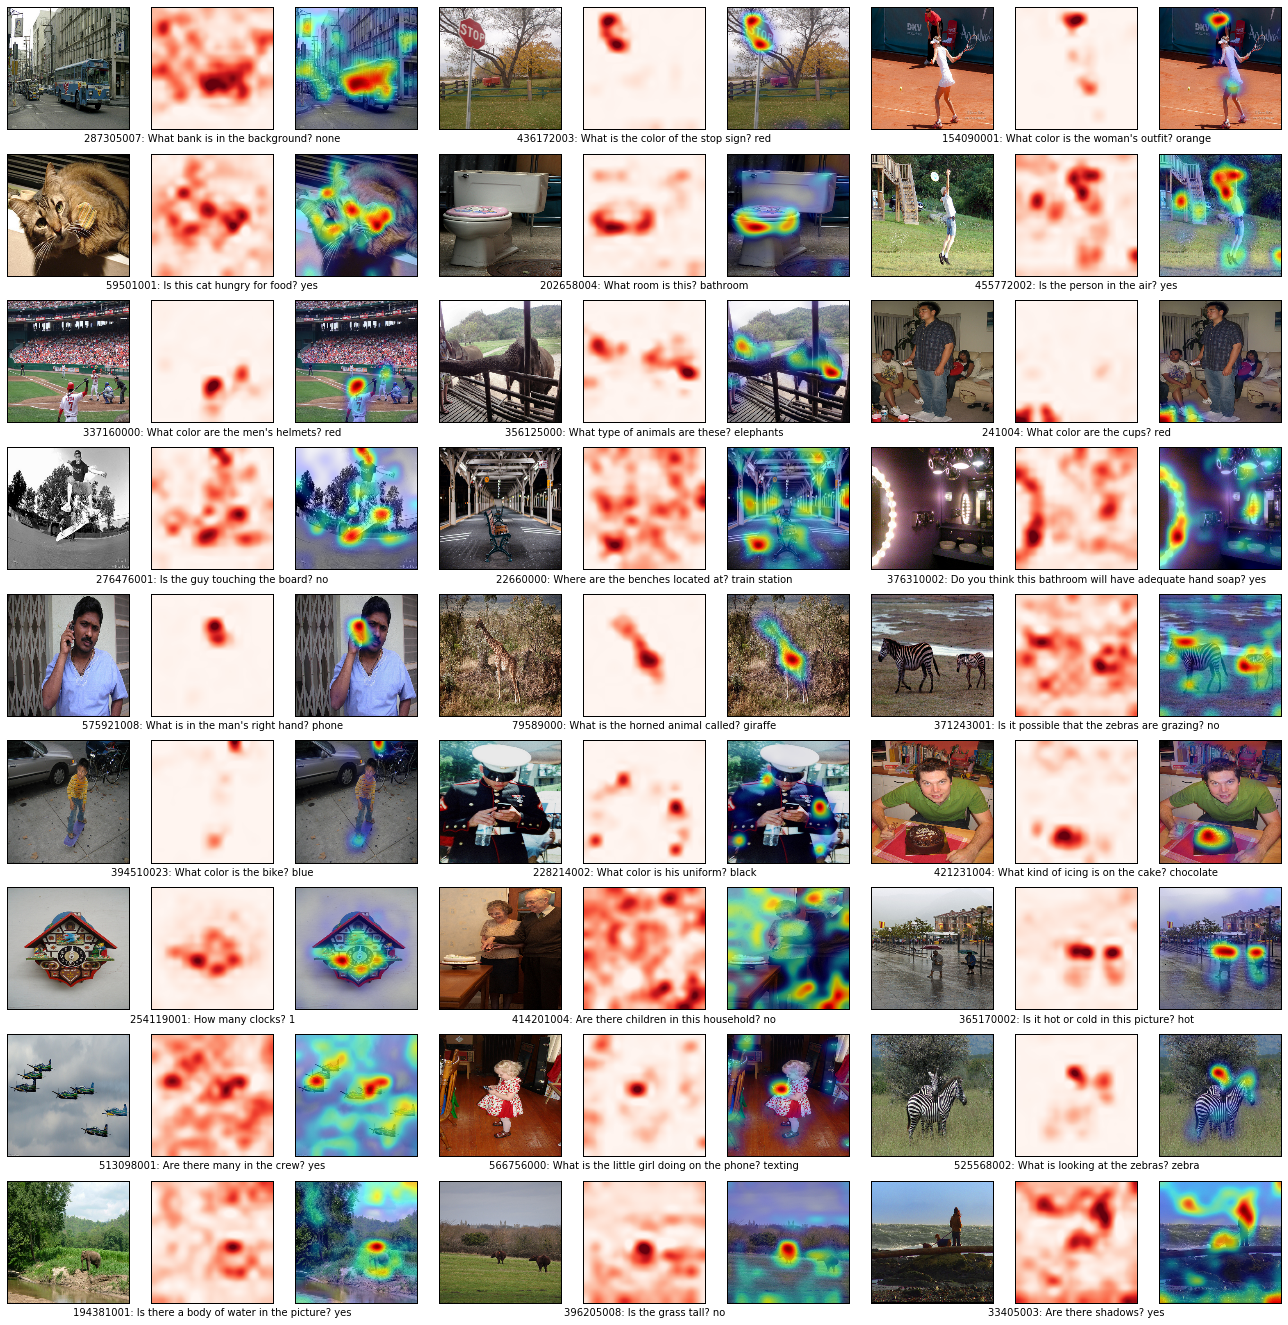

In [11]:
num_rows = 9
num_cols = 9 # multiple of 3

fig = plt.figure(figsize = (num_cols * 2, num_rows * 2))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0)

for i in range(num_rows * num_cols / 3):
    idx = np.random.randint(len(data))
    orig_img = scipy.misc.imread('/srv/share/data/mscoco/images/' + data[idx]['img_path'].replace('val2017', 'val2014'))
    orig = scipy.misc.imresize(orig_img, (300, 300), interp='bicubic')
    atten = scipy.misc.imresize(att['maps'][0][idx], (300, 300), interp='bicubic')
    
    ax = plt.subplot(num_rows, num_cols, i*3+1)
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis='y',which='both',left='off',right='off',labelleft='off')
    ax.imshow(orig)

    ax = plt.subplot(num_rows, num_cols, i*3+2)
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis='y',which='both',left='off',right='off',labelleft='off')
    ax.imshow(atten, alpha=1.0, cmap=plt.cm.Reds)
    ax.set_xlabel(str(data[idx]['ques_id']) + ': ' + data[idx]['question'] + ' ' + res[idx]['answer']\
                  , fontsize=10, labelpad=5, ha='center')

    ax = plt.subplot(num_rows, num_cols, i*3+3)
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis='y',which='both',left='off',right='off',labelleft='off')
    ax.imshow(get_blend_map(orig / 255.0, att['maps'][0][idx]))

In [12]:
fig.savefig('figures/san1_results_9x3.png', dpi=75, bbox_inches='tight')